In [27]:
import csv
import re
import matplotlib
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import *

from matplotlib import style
import matplotlib.gridspec as gridspec

matplotlib.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)


plt.style.context("seaborn-whitegrid")
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.25

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


### 1. some important files related to gatk copy number analysis 


* matlab: /gsc/software/linux-x86_64-centos5/matlab-2013a/bin/matlab  

* gistic refgenefile including both the cytoband and ref genes: /projects/da_workspace/software/gistic/rg.txt 

* cumulative chromosome length: /home/szong/projects/resource/chromosome_accumulative_length.txt'  

* curated germline cnvs from Andrew Cherniack, use this to filter out germline cnv
/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/CNV.hg19.bypos.111213.from.Andrew.Cherniack.txt

### 2. remove germline cnvs

* https://www.bcgsc.ca/jira/browse/DA-243?jql=text%20~%20%22cervical%20copy%20number%22  
* In case people will worry that we have missed stuff, To remove a segment, it is required that 75% of the segment overlap with one of the germline regions sent by Andy C. 
* when comparing to 50% overlap, 75% overlap just removed 2% less segements, from 16% to 14%. This indicates that we won't have tons of germline CNVs in our final segment file.
* In TCGA, it looks like they actually ended up removing 75% of the segments. no wonder the TCGA copy number results look super clean.

### 3. thresholds for copy gain/loss: gatk log2 ratio > 0.1 gain, gatk log2 ratio < -0.1 loss

* see DA-243 for how the thresholds are determined, link: https://www.bcgsc.ca/jira/browse/DA-243?jql=text%20~%20%22cervical%20copy%20number%22 
* there is a back and forth for this. Initially I used this (gatk log2 ratio > 0.25 gain, gatk log2 ratio < -0.25 loss) based on a paper (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4392457/). 
* According to Andrew Cherniack, they usually use 0.1 for SNP array data because this is ratio they are confident there are copy changes. 
* also in GISITC documentation: https://gatkforums.broadinstitute.org/firecloud/discussion/8254/gistic2-0.
it uses 0.1 as the threshold to decide if a segment is amplified or deleted.  

### 4. GISTIC q value threshold: 0.25

* There is some discrepancy on the q significant threshold between old and new gistic documentation. 
* /home/szong/bin/GISTIC_2_0_22/GISTICDocumentation_standalone.htm, the q threshold is set to 0.25 by default.
* https://gatkforums.broadinstitute.org/firecloud/discussion/8254/gistic2-0, This is the newer documentation and the q threshold is set to 0.1 by default.
* TCGA gistic analysis used 0.25 as threshold, for comparison I picked 0.25 to ensure consistence.

### 5. Some points made by Andrew Cheniack quoted as below:

1) The germline CNV file was manually curated from normal SNP array data. I have attached our germline CNV file. This is aligned to HG19. I believe a newer HG38 file exists on the GDC portal. If not, I can dig one up if you need it..

2) GISTIC doesn't compare Broad and Focal alterations together because they are two really different things. The arm level significance file is named:
broad_significance_results.txt

3) We usually use 0.1 because that was the lowest level from SNP array data that we felt confident in calling as an alteration. If you want to use 0.25 that is OK.
It's whatever you feel comfortable with.

4) 30 genes was an arbitrary number used to make the figure look good. Peaks with 100s of genes are not well defined and so take them with a grain of salt. If you have a peak with ~50 genes with a well known oncogene in the middle, I wouldn't ignore it.

5) The germline CNV list should be good for any conhort. The only caveat is that it may be incomplete if you are profiling an ethnic group that is not well represented TCGA.
6) BTW germlines CNVs are easy to identify. What you will see is CNVs with similar boundaries that maybe either amplified or deleted. (see example below)

Andy

### 6. TCGA copy number

* i can load the gatk seg file into igv for visualization. the file extension needs to be .seg

* decided to use the TCGA file with germline CNVs removed for the comparison I used the same TCGA curated germline events to filter out germline events from HTMCP cohort as well. this is only true if the file Andy C sent to me is exactly the same file they used for TCGA. 

* i downloaded the population CNVS here: is this from 1000 genomes
/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/population_cnv.txt

* TCGA core data freeze list: 178 samples with SNP6 array copy number data. extended data include additional 50 samples.

* snp6 copy number analysis was applied to the 178 core samples. in supplimentary, it states "Somatic copy number alterations in 178 CESC tumors were determined with SNP 6.0 arrays. "

* <font color='red'>
TCGA excluded peaks with more than 30 genes. also TCGA removed germline CNVs
</font>

* GISTIC2.0 amplification and deletion plots within copy number clusters. Chromosomal locations for peaks of significantly recurrent focal amplifications (red) and deletions (blue) are plotted by −log10 q value for the high (CN High) and low (CN Low) copy number clusters. Peaks are annotated with cytoband and candidate driver genes. The total number of genes in the peak region is indicated in parentheses. Peaks with more than 30 genes in the peak region are excluded. Any genes annotated have a significant positive correlation with mRNA expression

* TCGA data are download here: http://firebrowse.org/
, http://gdac.broadinstitute.org/runs/stddata__2016_01_28/data/CESC/20160128/
. In firbrowse, there are 295 samples with snp6 copy number results including 586 tumour or normals. not sure why. but it makes sense to have normals in this file because copy number ratio is standardardized to a panel of normals. so normals can be compared to the panel as well.

* TCGA copy number analysis GISTIC results are here with 295 patients: http://gdac.broadinstitute.org/runs/analyses__2016_01_28/reports/cancer/CESC-TP/CopyNumber_Gistic2/nozzle.html

* TCGA CESC had 178 core samples plus 50 extended cases. but in firebrowse we got 295 samples for the cesc. not sure why. i am confused. so to keep it simple, I will stick to the 178 samples for the purposes of comparison with HTMCP. the 178 core samples include both squamous and adeno cases. so not like we only look at squamous cases. should be fine.

* To decide which file to use. "_scna_minus_germline_cnv_" has much less rows, indicating germline cnvs were removed. maybe one normal against a panel of normal can detect germline cnvs, so the file excluded these events. we need to removed germline events for HTMCP cohort as well. 

* to determine if a segment is amplfied or deleted based on the segment_mean value, (logT/N ratio). I tend to use cutoffs; amp>=0.58=log2(3/2); del <=-1=log2(1/2), this seems to be too stringent. 

* Below are some relevant references:
* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4392457/. There are no standardised log2 ratio cut-offs to define low-amplitude copy number gain/loss and high amplitude amplification/deletion. Based on the available published literature, we used a log2 ratio cut-off of +/− 0.25 to define copy number gain/loss and a log2 ratio cut-off of +/− 0.8 to define amplification and deletion [7,18,19].

* https://www.nature.com/articles/nature20805. esophageal copy number comparison with ESCC and EAC

* this google post has some useful information as well: https://groups.google.com/a/broadinstitute.org/forum/#!topic/gdac-users/__zdXDE-Z5U

* this talks about the germline CNVs identified in 1000 genomes. https://www.biostars.org/p/174343/

* this describes how GISTIC works: http://www.pnas.org/content/104/50/20007.full


### 7. TCGA Copy number analysis method from the paper
* DNA from each tumour or germline sample was hybridized to Affymetrix SNP 6.0 arrays using protocols at the Genome Analysis Platform of the Broad Institute as previously described51. Briefly, Birdseed was used to infer a preliminary copy number at each probe locus from raw .cel files52. For each tumour, genome-wide copy number estimates were refined using tangent normalization, in which tumour signal intensities are divided by signal intensities from the linear combination of all normal samples that are most similar to the tumour16. Individual copy number estimates then underwent segmentation using circular binary segmentation53, and segmented copy number profiles for tumour and matched control DNAs were analysed using Ziggurat Deconstruction54. Significance of copy number alterations were assessed from the segmented data using GISTIC2.0 (version 2.0.22)54. For the purpose of this analysis, an arm-level event was defined as any event spanning more than 50% of a chromosome arm. For copy number-based clustering, tumours were clustered based on copy number at regions using GISTIC analysis. Clustering was done in R on the basis of Euclidean distance using Ward’s method. Allelic and integer copy number, tumour purity and tumour ploidy were calculated using the ABSOLUTE algorithm55.



# goals

* to display the copy number landscape using gatk cnv results
* to compare significant arm level alterations among three groups: tcga, htmcp hiv+, and htmcp hiv-, all comparisons are made against hiv- group

# constants

In [1]:
# suggested by Andrew Cherniack
amp_threshold = 0.1 # gatk log2 ratio > 0.1 copy gain
del_threshold = -0.1 # gatk log2 ratio < -0.1 copy loss
arm_threshold = 0.25 # q value < 0.25 significant events
num_tcga_patients = 177
num_htmcp_patients = 118
num_htmcp_hiv_pos_patients = 73
num_htmcp_hiv_neg_patients = 45

# files

In [2]:
wkdir = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/'
bindir = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/bin_segs/'
chr_accu_length_f = f'{wkdir}chromosome_accumulative_length.txt'
chromosomef = f'{wkdir}chromosome_coordinates.txt'

# this removed germline cnvs
tcga_cn_file = '/home/szong/bin/GISTIC_2_0_22/tcga/segmentationfile.txt'
# tcga_cn_file is extracted from below minus_germline files downloaed from firebrowse
# tcga_cn_file = '/projects/trans_scratch/validations/workspace/szong/Cervical/tcga_cn/gdac.broadinstitute.org_CESC.Merge_snp__genome_wide_snp_6__broad_mit_edu__Level_3__segmented_scna_minus_germline_cnv_hg19__seg.Level_3.2016012800.0.0/CESC.snp__genome_wide_snp_6__broad_mit_edu__Level_3__segmented_scna_minus_germline_cnv_hg19__seg.seg.txt'
# tcga_cn_file = '/projects/trans_scratch/validations/workspace/szong/Cervical/tcga_cn/gdac.broadinstitute.org_CESC.Merge_snp__genome_wide_snp_6__broad_mit_edu__Level_3__segmented_scna_hg19__seg.Level_3.2016012800.0.0/CESC.snp__genome_wide_snp_6__broad_mit_edu__Level_3__segmented_scna_hg19__seg.seg.txt'
tcga_core_sample_file = '/projects/trans_scratch/validations/workspace/szong/Cervical/tcga_cn/TCGA_178_core_samples.txt'
htmcp_hiv_neg_file = '/home/szong/bin/GISTIC_2_0_22/gatk_118_HIV_neg/segmentationfile.txt'
htmcp_hiv_pos_file = '/home/szong/bin/GISTIC_2_0_22/gatk_118_HIV_pos/segmentationfile.txt'
# htmcp_file = '/home/szong/bin/GISTIC_2_0_22/gatk_118_patients/segmentationfile.txt'
hivpos_uniqamp_armsf = f'{wkdir}hivpos_uniqamp_arms_{arm_threshold}.txt'
hivneg_uniqamp_armsf = f'{wkdir}hivneg_uniqamp_arms_{arm_threshold}.txt'
hivpos_uniqdel_armsf = f'{wkdir}hivpos_uniqdel_arms_{arm_threshold}.txt'
hivneg_uniqdel_armsf = f'{wkdir}hivneg_uniqdel_arms_{arm_threshold}.txt'
tcga_uniqdel_armsf = f'{wkdir}tcga_uniqdel_arms_{arm_threshold}.txt'
tcga_uniqamp_armsf = f'{wkdir}tcga_uniqamp_arms_{arm_threshold}.txt'
hivneg2_uniqdel_armsf = f'{wkdir}hivneg2_uniqdel_arms_{arm_threshold}.txt'
hivneg2_uniqamp_armsf = f'{wkdir}hivneg2_uniqamp_arms_{arm_threshold}.txt'



In [5]:
f2_1 = '/home/szong/projects/resource/chrominfo.txt'
df2_1 = pd.read_csv(f2_1, sep='\t', usecols=['#chrom', 'size'])
df2_1['chr'] = df2_1['#chrom'].apply(lambda x: x.replace('chr', ''))
chr_sizes = df2_1.set_index('chr').drop('#chrom', axis=1)
chr_sizes = chr_sizes.reset_index().replace('X', '23').replace('Y', '24').iloc[:24,].set_index('chr')
chr_sizes.index = chr_sizes.index.astype(int)
chr_sizes = chr_sizes.sort_index()
chr_sizes.head(2)
# initiate occupied label coordinates dict
chr_length = chr_sizes['size']#.astype(str)
y_coords = np.arange(7, .5, -0.5)

,size
chr,
1,249250621
2,243199373


# 3. plot cnvs

In [6]:
def plot_cnv(ax, baseline, amps, dels, num_patients, vlns):
    ticks = [0, 0.4, 0.8, 1.2, 1.6]
    ticklabels = [0.8, 0.4, 0, 0.4, 0.8]
    ax.set_yticks(ticks, minor=False)
    ax.set_yticklabels(ticklabels, minor=False)
    # ax.set_frame_on(False) # this turn off frame
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.axes.get_xaxis().set_visible(False)
    _ = ax.hlines(baseline, 0, vlns[-2], color='black', linewidth=.7)
    for vl in vlns:
        _ = ax.vlines(vl, 0, 1.6, color='gray', linestyle='--', linewidth=.5)
    
#     _ = axhline(baseline + 1, color='gray', linestyle='--', linewidth=.5)
#     _ = axhline(baseline - 1, color='gray', linestyle='--', linewidth=.5)
    coordinates, fractions = get_coordinates_fractions(amps, num_patients)

    plot_fraction(coordinates, fractions, baseline, 'amps', ax)
    coordinates, fractions = get_coordinates_fractions(dels, num_patients)
    plot_fraction(coordinates, fractions, baseline, 'dels', ax)

In [7]:
# plot baseline
start = 0
end = 0
# baseline = 1
vlns = []
mpnts = []
for ch, length in enumerate(chr_length[:-1]):
    ch+=1
    end+=length
    midpoint = (start + end)/2
    mpnts.append(midpoint)
#     _ = ax0.text(midpoint, 1, ch, ha='center')
    if ch %2 == 1:
        vlns.append(start)
        vlns.append(end)
#         _ = fill([start, end, end, start], [0, 0, 11, 11], 'b', alpha=0.1, edgecolor='b')
#         _= ax0.vlines(start, 0, 10, color='gray', linestyle='--', linewidth=.5)
#         _= ax0.vlines(end, 0, 10, color='gray', linestyle='--', linewidth=.5)
    start+=length
#     _ = ax0.text(midpoint, 1, ch, ha='center')


In [8]:
def plot_cytobands(df, ax, clr, y_coord):
    """
    keep in mind sometime notebook does render properly, some lines seem missing, 
    but it will show up when you open the png file. 
    """
    for ix, row in df.iterrows():
        chrom = row.chr
        start = row.start
        end = row.end
        cytoband = row.cytoband
        print(start, end, (end-start), cytoband)
        ax.hlines(y_coord, start, end, color=clr, linewidth=14) 

# plot cytoband

In [9]:
# plot chromosomes
f3 = '/home/szong/projects/resource/hg19_cytoband_ucsc.txt'
df_cytoband = pd.read_csv(f3, header=None, sep='\t')
df_cytoband.columns = ['chr', 'start', 'end', 'cytoband', 'comments']
df_cytoband['cytoband'] = df_cytoband.chr + df_cytoband['cytoband']
df_cytoband['chr'] = df_cytoband['chr'].replace({'X':'23', 'Y':'24'}).astype(str)

df_cytoband.head(2)
df_cytoband.tail()
df_cytoband.shape
df_cytoband.dtypes

,chr,start,end,cytoband,comments
0,1,0,2300000,1p36.33,gneg
1,1,2300000,5400000,1p36.32,gpos25


,chr,start,end,cytoband,comments
857,24,15100000,19800000,Yq11.221,gpos50
858,24,19800000,22100000,Yq11.222,gneg
859,24,22100000,26200000,Yq11.223,gpos50
860,24,26200000,28800000,Yq11.23,gneg
861,24,28800000,59373566,Yq12,gvar


(862, 5)

chr         object
start        int64
end          int64
cytoband    object
comments    object
dtype: object

In [10]:
chromosomes = pd.read_csv(chr_accu_length_f, sep='\t')
chromosomes[:4]
chromosomes.dtypes

,chrom,length,cumulative_length
0,0,0,0
1,1,249250621,249250621
2,2,243199373,492449994
3,3,198022430,690472424


chrom                int64
length               int64
cumulative_length    int64
dtype: object

In [11]:
chromosomes['end'] = chromosomes.cumulative_length.shift(-1)
chroms = chromosomes.loc[0:23,['cumulative_length','end']]
chroms['chrom'] = [i for i in range(1, 25)]
# chroms.to_csv(chromosomef, index=False)

# final plot

In [12]:
def calculate_fractions(df):
    end = 0
    all_positions = []
    all_fractions = []
    for ch, length in enumerate(chr_length):
        ch+=1
        positions = list(end + np.array(df.iloc[df.index.get_level_values('bin_chr') == ch].index.get_level_values('bin_start').tolist()))
        all_positions = all_positions + positions
        fractions = df.iloc[df.index.get_level_values('bin_chr') == ch]['fraction_patients'].tolist()
        all_fractions = all_fractions + fractions
        end+=length
    return (all_positions, all_fractions)

In [13]:
def get_coordinates_fractions(indf, num_patients):
    df = reindex_df(indf, num_patients, df11)
    coordinates, fractions = calculate_fractions(df)
    return (coordinates, fractions)

In [14]:
def reindex_df(indf, num_patients, df11):
    df = indf.set_index(['bin_chr', 'bin_start', 'bin_end']).reindex(df11.index)
    df.fillna(0, inplace=True)
    df['fraction_patients'] = df.patient/num_patients
    df.drop('patient', inplace=True, axis=1)
    return df

In [15]:
def plot_fraction(coordinates, fractions, baseline, cnv_type, ax):
    baseline_postions = [baseline] * len(coordinates)
    if cnv_type.lower() == 'amps':
        fractions = baseline + np.array(fractions)
        color = 'red'
    elif cnv_type.lower() == 'dels':
        fractions = baseline - np.array(fractions)
        color = 'blue'
    ax.fill_between(coordinates, 
                    fractions, 
                    baseline_postions, 
                    color=color, 
                    alpha=1)

In [19]:
# tcga
f = f'{wkdir}tcga_cnv_amps_bins_1kb.txt.patients'
tcga_recur_amps = pd.read_csv(f, sep='\t')
f = f'{wkdir}tcga_cnv_dels_bins_1kb.txt.patients'
tcga_recur_dels = pd.read_csv(f, sep='\t')

# hiv pos 
f = f'{wkdir}htmcp_hiv_pos_cnv_amps_bins_1kb.txt.patients'
htmcp_hiv_pos_recur_amps = pd.read_csv(f, sep='\t')
f = f'{wkdir}htmcp_hiv_pos_cnv_dels_bins_1kb.txt.patients'
htmcp_hiv_pos_recur_dels = pd.read_csv(f, sep='\t')

# hiv neg
f = f'{wkdir}htmcp_hiv_neg_cnv_amps_bins_1kb.txt.patients'
htmcp_hiv_neg_recur_amps = pd.read_csv(f, sep='\t')
f = f'{wkdir}htmcp_hiv_neg_cnv_dels_bins_1kb.txt.patients'
htmcp_hiv_neg_recur_dels = pd.read_csv(f, sep='\t')

In [18]:
# chromosome arm coordinates
f = f'{wkdir}chromosome_arm_coordinates.txt'
arm_coords = pd.read_csv(f, sep='\t')
arm_coords[:2]

# unique arm level alterations
hivpos_uniqamp_arms = pd.read_csv(hivpos_uniqamp_armsf, header=None)[0].tolist()
hivpos_uniqamp_arms

hivneg_uniqamp_arms = pd.read_csv(hivneg_uniqamp_armsf, header=None)[0].tolist()
hivneg_uniqamp_arms

# no hivneg uniq del 
# hivneg_uniqdel_arms = pd.read_csv(hivneg_uniqdel_armsf, header=None)[0].tolist()
# hivneg_uniqdel_arms

hivpos_uniqdel_arms = pd.read_csv(hivpos_uniqdel_armsf, header=None)[0].tolist()
hivpos_uniqdel_arms

tcga_uniqdel_arms = pd.read_csv(tcga_uniqdel_armsf, header=None)[0].tolist()
tcga_uniqdel_arms

# no tcga uniqamp events
# tcga_uniqamp_arms = pd.read_csv(tcga_uniqamp_armsf, header=None)[0].tolist()
# tcga_uniqamp_arms

# hivneg2  
hivneg2_uniqdel_arms = pd.read_csv(hivneg2_uniqdel_armsf, header=None)[0].tolist()
hivneg2_uniqdel_arms

hivneg2_uniqamp_arms = pd.read_csv(hivneg2_uniqamp_armsf, header=None)[0].tolist()
hivneg2_uniqamp_arms

,chrom,arm,start,end,chr_arm
0,1,p,1,125000000,1p
1,1,q,125000001,249250621,1q


['6p', '16p', '14q', '9q', '16q', '9p']

['3p', '15q']

['13q', '5q', '21q', '4q']

['22q', '17p', '5q', '4q', '6q', '3q', '10q', '13q', '18q', '8p', '9p']

['21p']

['3p', '8p', '15q']

In [21]:
def plot_arms(arms, arm_coords, ax, alteration_type, edgeclr, offset, mk): # w/o border
    for arm in arms:
        df = arm_coords[arm_coords['chr_arm']==arm]
#         print(df)
        start = df.loc[df.index[0], 'start']
        end = df.loc[df.index[0], 'end']
        if alteration_type.lower() == 'amp':
            faceclr = 'red'
            y1 = 0.8
            y2 = 1.5
        elif alteration_type.lower() == 'del':
            faceclr = 'blue'
            y1 = 0
            y2 = 0.1
        else: print("Error! invalid copy number type.")
        
#         print(arm, start, end)
        ax.plot(start+offset, y2, color='black', marker=mk, markersize=4)
        ax.add_patch(matplotlib.patches.Rectangle((start,y1), end-start, 0.8,  
                                                  edgecolor=edgeclr, facecolor=faceclr, 
                                                  alpha=0.3, linewidth=2))


In [22]:
def plot_chromosomes(df, ax):
    # plot chromosome names


    # plot chromosomes rectangles
    chr_clrs = ['white' if i%2==0 else 'black' for i in df['chrom'] ]
    text_clrs = chr_clrs + ['white']
#     print(chr_clrs)
#     print(text_clrs)
    for ix, row in df.iterrows():
        chrom = int(row.chrom)
        start = row.start
        end = row.end

        _ = ax.add_patch(matplotlib.patches.Rectangle((start,0), end-start, 1.6,  
                                              edgecolor='gray', facecolor=chr_clrs[chrom-1], 
                                              alpha=1, linewidth=2))
        if chrom <= 23:
            _ = ax.text(int((start + end)/2), 0.6, chrom, ha='center', color=text_clrs[chrom])
        else:
            _ = ax.text(int((start + end)/2), 0.6, 'X', ha='center', color=text_clrs[chrom])
            

In [23]:
chrdf = pd.read_csv(chromosomef)
chrdf.columns = ['start', 'end', 'chrom']
chrdf[:2]

,start,end,chrom
0,0,249250621.0,1
1,249250621,492449994.0,2


In [24]:
f11 = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/bin_segs/chr_bins.txt'
df11 = pd.read_csv(f11, sep='\t', header=None)
df11.columns = ['bin_chr', 'bin_start', 'bin_end']
df11.set_index(['bin_chr', 'bin_start', 'bin_end'], inplace=True)
# df11['patient'] = 0
df11.head()

Empty DataFrame
Columns: []
Index: [(1, 1, 1000), (1, 1001, 2000), (1, 2001, 3000), (1, 3001, 4000), (1, 4001, 5000)]

In [25]:
htmcp_hiv_pos_recur_amps.head(2)
htmcp_hiv_pos_recur_dels.columns


,bin_chr,bin_start,bin_end,patient
0,1,10001,11000,10
1,1,11001,12000,10


Index(['bin_chr', 'bin_start', 'bin_end', 'patient'], dtype='object')

(0.0, 1.0, 0.0, 1.0)

(0, 3188119038.3) (0, 1.6)


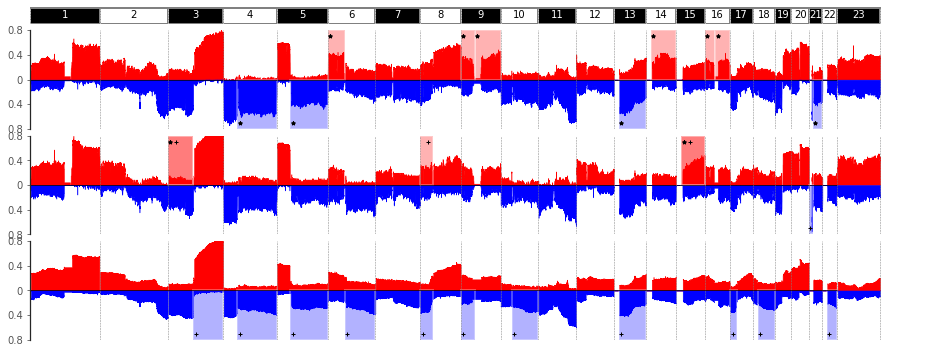

In [28]:
baseline = 0.8
fig = plt.figure(figsize=(16, 10), facecolor='white')
gs = gridspec.GridSpec(6, 1, height_ratios=[1, 6, 6, 6, 6, 6], 
                       hspace=0.08)  # vertical space

# plot chromosomes
ax0 = plt.subplot(gs[0], facecolor='white')
ax0.axis('off')
chrdf = chrdf.iloc[:23,:]

# figuring out xlim and ylim
for vl in vlns:
    _ = ax0.vlines(vl, 0, 1.6, color='white', linestyle='--', linewidth=.5)
xlims = (0, ax0.get_xlim()[1])
ylims = (0, ax0.get_ylim()[1])
_= ax0.set_xlim(xlims)
_ = ax0.set_ylim(ylims)
ylims = (0,1.6)
print(xlims, ylims)
plot_chromosomes(chrdf, ax0)

# plot htmcp cnvs hiv+ 73 patients
ax1 = plt.subplot(gs[1], facecolor='white')
plot_cnv(ax1, baseline, htmcp_hiv_pos_recur_amps, htmcp_hiv_pos_recur_dels, num_htmcp_hiv_pos_patients, vlns)
plot_arms(hivpos_uniqamp_arms, arm_coords, ax1, 'amp', 'white', 9e6, '*')
plot_arms(hivpos_uniqdel_arms, arm_coords, ax1, 'del', 'white', 9e6, '*')
_ = ax1.set_xlim(xlims)
_ = ax1.set_ylim(ylims)

# plot htmcp cnvs hiv- 45 patients
ax2 = plt.subplot(gs[2], facecolor='white')
plot_cnv(ax2, baseline, htmcp_hiv_neg_recur_amps, htmcp_hiv_neg_recur_dels, num_htmcp_hiv_neg_patients, vlns)
plot_arms(hivneg_uniqamp_arms, arm_coords, ax2, 'amp', 'white', 9e6, '*')
plot_arms(hivneg2_uniqamp_arms, arm_coords, ax2, 'amp', 'white', 3e7, '+')
plot_arms(hivneg2_uniqdel_arms, arm_coords, ax2, 'del', 'white', 3e6, '+')
_ = ax2.set_xlim(xlims)
_ = ax2.set_ylim(ylims)
# no hivneg uniq deletions


# plot tcga cnvs
ax3 = plt.subplot(gs[3], facecolor='white')
plot_cnv(ax3, baseline, tcga_recur_amps, tcga_recur_dels, num_tcga_patients, vlns)
plot_arms(tcga_uniqdel_arms, arm_coords, ax3, 'del', 'white', 9e6,'+')
_ = ax3.set_xlim(xlims)
_ = ax3.set_ylim(ylims)

# plt.savefig(f'{wkdir}cnvs_publication_armthreshold_{arm_threshold}_alterthreshold_{amp_threshold}.pdf', dpi=300, bbox_inches='tight')
# plt.savefig(f'{wkdir}cnvs_publication_{arm_threshold}.png', dpi=300, bbox_inches='tight')

# Take home message

1. hiv + group has more uniq arm level alterations, including both amps and dels. HIV- has 2 unique arms amplified, 3p and 15q, but no unique arm level deletions.

2. hiv- group and tcga are more similar in terms of broad copy number alterations, you can see this by examing the significant arm alterations unique to HIV+ group. 

3. tcga reports more arm deletions while htmcp reports more arm amplifications. tcga reports 9 unique arm deletions, htmcp reports 2 unique arm deletions 21pq. htmcp reports 5 unique arm amplifications.
4. keep in mind this plot does not show the amplitude of the alterations in each and all patients. it only shows the frequency. This is a limitation. it is entirely possible a region is altered at lower frequency, but very high magnitude of gain and loss. So it turns out to be more significant than the higher frequency in another cohort. GISTIC looks for both occurrence and amplitude. 
5. look at the segment_mean distribution: tcga amp mean =0.75, del=-1.2; hiv+ amp=0.62, del=-0.9; hiv- amp=0.58, del=-1.0




what the plot is showing:
1. shows somatic copy number alteration landscape in htmcp hiv+ and - group and tcga cesc cohort
2. shows the fraction of patients have copy gain or loss in each 1kb bin along the entore genome
3. copy gain is defined as gatk copy ratio of tumour to a panel of normals >0.1, and copy loss is defined as segments with copy ratio less than -0.1.
4. unique arm alterations are highlighted in both hiv+ and - group
5. unique arm alterations for tcga and htmcp are highlighted in the last panel. highlights with a black border are unique to tcga 